Esse notebook tem como objetivo o desenvolvimento do quinto modelo de behavior solicitados pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.
Esse modelo irá utilizar toda a base BUREAU + base TELCO + base Cadastro +booking de variáveis criado com base recarga


#BIBLIOTECAS E INSTALAÇÕES

In [ ]:
# manipulação, leitura e vizualização de dados bibiliotecas
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [ ]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_rows', 145)
pd.set_option('display.max_columns', 145)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [ ]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
!pip install category_encoders
from category_encoders import TargetEncoder, WOEEncoder, CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectKBest, f_classif, SelectFromModel
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.3 MB/s eta 0:00:00


#FUNÇÕES

In [ ]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [ ]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
import sklearn.feature_selection

# Get a list of all attributes (modules, functions, classes) in sklearn.feature_selection
available_modules = dir(sklearn.feature_selection)

# Filter out private/internal attributes and print them
print("Available modules and functions in sklearn.feature_selection:")
for item in sorted(available_modules):
    if not item.startswith('_'): # Exclude private members
        print(f"- {item}")

Available modules and functions in sklearn.feature_selection:
- GenericUnivariateSelect
- RFE
- RFECV
- SelectFdr
- SelectFpr
- SelectFromModel
- SelectFwe
- SelectKBest
- SelectPercentile
- SelectorMixin
- SequentialFeatureSelector
- VarianceThreshold
- chi2
- f_classif
- f_oneway
- f_regression
- mutual_info_classif
- mutual_info_regression
- r_regression


In [ ]:
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()

def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# def select_features_by_iv_with_progress(df, target, iv_cutoff_ratio=1.0):
#     from tqdm import tqdm
#     iv_stats = []
#     for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
#         if col != target:
#             iv_value = calculate_iv(df, col, target)
#             iv_stats.append({
#                 'Variable': col,
#                 'IV': iv_value,
#                 'Predictiveness': classify_iv(iv_value)
#             })

#     iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
#     max_iv = iv_df['IV'].max()
#     cutoff_value = iv_cutoff_ratio * max_iv
#     selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

#     return selected_features, iv_df

def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

## base bureal

In [ ]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#lendo dataset
df_bureal = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_score_bureau_movel/base_score_bureau_movel/BASECPFUNICOparquetunico/part-00000-98e88720-cfb7-4d91-aadf-a26be5bb24ce-c000.snappy.parquet')

In [ ]:
#tamanho do dataset
df_bureal.shape

(1272095, 5)

In [ ]:
#vendo 5 primeiras linhas
df_bureal.head(5)

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


- O Grupo controle será removido da base do modelo uma vez que é um grupo de pessoas em que o modelo não é aplicado.
- O grupo controle pode ser identificado a partir do 6º e 7º dígitos do CPF, considerando as combinações ZZ e ZX.

In [ ]:
# Filtra o DataFrame para remover linhas onde o 6º e 7º dígitos de NUM_CPF são 'ZZ' ou 'ZX'
df_bureal_sem_grupo_controle = df_bureal[~df_bureal['NUM_CPF'].str[5:7].isin(['ZZ', 'ZX'])]

# Exibe o novo formato do DataFrame para verificar
print(f"Shape of df_bureal_sem_grupo_controle_pd (rows, columns): {df_bureal_sem_grupo_controle.shape}")
display(df_bureal_sem_grupo_controle.head())

Shape of df_bureal_sem_grupo_controle_pd (rows, columns): (1213448, 5)


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02
0,ZZZZZX7XWY8,202410,0,562,636
1,ZZZZZX88YXY,202410,1,546,518
2,ZZZZZYT7XYT,202410,0,621,750
3,ZZZZZNTXY9Z,202410,1,609,679
4,ZZZZZ79ZXUX,202410,0,621,722


In [ ]:
#% de CPFs que pertecem ao grupo controle:
original_num_rows = 1272095
filtered_num_rows = df_bureal_sem_grupo_controle.shape[0]

control_group_count = original_num_rows - filtered_num_rows
percentage_control_group = (control_group_count / original_num_rows) * 100

print(f"CPFS que pertencem ao grupo controle: {control_group_count}")
print(f"% CPFS do grupo controle em relação ao total da base: {percentage_control_group:.2f}%")

CPFS que pertencem ao grupo controle: 58647
% CPFS do grupo controle em relação ao total da base: 4.61%


In [ ]:
#GERANDO METADADOS DA TABELA:
generate_metadata(df_bureal_sem_grupo_controle)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,NUM_CPF,object,0,0.000000,1213448
1,SAFRA,object,0,0.000000,6
2,FPD_SCORE,object,0,0.000000,2
3,SCORE_01,object,8216,0.680000,296
4,SCORE_02,object,518,0.040000,584


In [ ]:
#tranformando tipo de dados das colunas para o mais adequado pre-processamento
import pandas as pd

# 1. Create a new column 'SAFRA_DATA' from 'SAFRA' in datetime format
df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')

# 2. Convert 'FPD_SCORE', 'SCORE_01', and 'SCORE_02' to nullable integer types
# Use errors='coerce' to turn unparseable values into NaN, and Int64Dtype to preserve NaNs
df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_01'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_01'], errors='coerce').astype(pd.Int64Dtype())
df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())

# Display the dtypes to verify the changes
print(df_bureal_sem_grupo_controle.dtypes)

# Display the head to see the new SAFRA_DATA column
display(df_bureal_sem_grupo_controle.head())

/tmp/ipython-input-2940056879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SAFRA_DATA'] = pd.to_datetime(df_bureal_sem_grupo_controle['SAFRA'], format='%Y%m')
/tmp/ipython-input-2940056879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['FPD_SCORE'] = pd.to_numeric(df_bureal_sem_grupo_controle['FPD_SCORE'], errors='coerce').astype(pd.Int64Dtype())
/tmp/ipython-input-2940056879.py:10: SettingWithCopyWarning: 
A value is trying to be set on

NUM_CPF               object
SAFRA                 object
FPD_SCORE              Int64
SCORE_01               Int64
SCORE_02               Int64
SAFRA_DATA    datetime64[ns]
dtype: object


/tmp/ipython-input-2940056879.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = pd.to_numeric(df_bureal_sem_grupo_controle['SCORE_02'], errors='coerce').astype(pd.Int64Dtype())


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
0,ZZZZZX7XWY8,202410,0,562,636,2024-10-01
1,ZZZZZX88YXY,202410,1,546,518,2024-10-01
2,ZZZZZYT7XYT,202410,0,621,750,2024-10-01
3,ZZZZZNTXY9Z,202410,1,609,679,2024-10-01
4,ZZZZZ79ZXUX,202410,0,621,722,2024-10-01


In [ ]:
#Foi detectado no EDA que o SCORE 1 tem muitas linhas com valor 0 e também com valor 2, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)

/tmp/ipython-input-1078160896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_01'] = df_bureal_sem_grupo_controle['SCORE_01'].replace([0, 2], np.nan)


In [ ]:
#Foi detectado no EDA que o SCORE 2 tem muitas linhas com valor 1, isso será considerado um erro da base de dados, e por tanto,
# irão ser transformados em missing nesse primeiro momento para sofrerem estratégia de inputing posteriormente:
df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)

/tmp/ipython-input-1195080068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['SCORE_02'] = df_bureal_sem_grupo_controle['SCORE_02'].replace([1], np.nan)


In [ ]:
#GERANDO ESTATISTICAS:
df_bureal_sem_grupo_controle.describe(include = 'all')

,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA
count,1213448,1213448,1213448.000000,1203051.000000,1212065.000000,1213448
unique,1213448,6,<NA>,<NA>,<NA>,NaN
top,999998YZYNW,202412,<NA>,<NA>,<NA>,NaN
freq,1,214502,<NA>,<NA>,<NA>,NaN
mean,NaN,NaN,0.227489,589.268532,630.341749,2024-12-16 04:58:03.537160192
min,NaN,NaN,0.000000,403.000000,307.000000,2024-10-01 00:00:00
25%,NaN,NaN,0.000000,556.000000,560.000000,2024-11-01 00:00:00
50%,NaN,NaN,0.000000,588.000000,625.000000,2024-12-01 00:00:00
75%,NaN,NaN,0.000000,622.000000,698.000000,2025-02-01 00:00:00
max,NaN,NaN,1.000000,778.000000,917.000000,2025-03-01 00:00:00


## Base TELCO

In [ ]:
#lendo o dataset
df_telco = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_telco/base_telco/part-00000-aaca54c3-d121-4415-801d-1273c426bc22-c000.snappy.parquet')

In [ ]:
#tamanho da tabela
df_telco.shape

(1367104, 74)

In [ ]:
#olhando algumas linhas da tabela:
df_telco.head(5)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93
0,7779ZY78YXT,202411,1,1,CMV,PRE,1,1,0,80.93,97.8,0,99.93,90.01,53.58,21.04,51.64,76.16,95.76,36.55,99.31,99.58,62.91,64.11,49.69,0,0,304,0,304,0,304,304,50,50,0,29.13,41.67,0.18,304,304,100,98.37,83.91,87.01,0,86.17,76.16,27.82,47.18,100,100,100,0,304,304,304,0,304,304,304,304,304,304,304,304,1,3,6,0,1.33,1,2,0
1,777YXTNZWZN,202410,1,0,CMV,PRE,1,1,0,304,28.37,29.83,31.32,23.55,38.43,28.15,304,304,304,304,16.54,34.78,304,304,304,0,0,304,0,304,0,304,304,50,50,0,33.64,25,0.03,304,304,100,46.21,76.98,0,0,9.97,46.21,0,53.79,304,304,100,0,304,304,304,0,304,304,304,304,304,304,304,304,3,3,1,0,0.99,5,1,0
2,777ZXUXZZXT,202503,1,0,CMV,PRE,1,1,84.86,99.99,82.32,0,73.3,52.07,0,0,304,304,304,304,76.34,94.88,89.77,88.96,99.31,76.16,90.51,75,95.38,100,14.68,0,0,100,99.12,95.4,100,100,100,44.73,99.59,51.06,95.17,48.9,76.16,0,99.26,99.97,7.39,52.79,100,304,100,1000,304,304,304,0,304,304,304,304,304,304,304,304,3,1,1,17,1.24,5,1,1
3,777ZXZTUU7Y,202412,1,0,CMV,PRE,1,1,25.5,87.98,70.39,0,100,99.88,100,99.91,0,0,0,0,100,100,61.69,61.69,50.36,76.16,35.84,100,8.31,100,1.43,0,0,73.11,50.79,35.84,90.51,100,100,5.56,3.89,90.32,98.66,76.02,0,0,53.7,90.51,50.47,57.95,100,0,100,0,304,304,304,0,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304
4,7788N7YZN87,202412,1,0,CMV,PRE,1,1,0,70.39,77.85,0.89,76.74,55.53,34.47,21.07,13.34,37.99,37.89,13.21,71.13,92.34,49.3,55.11,26.1,0,0,304,0,304,0,304,304,50,50,0,0,16.67,0.01,304,304,100,86.17,81.19,32.15,0,53.7,90.51,23.37,55.26,100,100,100,1,3,5,5,1,0,1,1,100,1.03,6,1,1,0,1,1,100,1.02,1,1,6


In [ ]:
#alterando tipos de data da tabela telco conforme EDA feito anteriormente:
df_telco['var_28'] = df_telco['var_28'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_29'] = df_telco['var_29'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_30'] = df_telco['var_30'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_31'] = df_telco['var_31'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_32'] = df_telco['var_32'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_33'] = df_telco['var_33'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_34'] = df_telco['var_34'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_35'] = df_telco['var_35'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_36'] = df_telco['var_36'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_37'] = df_telco['var_37'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_38'] = df_telco['var_38'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_39'] = df_telco['var_39'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_40'] = df_telco['var_40'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_41'] = df_telco['var_41'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_42'] = df_telco['var_42'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_43'] = df_telco['var_43'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_44'] = df_telco['var_44'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_45'] = df_telco['var_45'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_46'] = df_telco['var_46'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_47'] = df_telco['var_47'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_48'] = df_telco['var_48'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_49'] = df_telco['var_49'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_50'] = df_telco['var_50'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_51'] = df_telco['var_51'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_52'] = df_telco['var_52'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_53'] = df_telco['var_53'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_54'] = df_telco['var_54'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_55'] = df_telco['var_55'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_56'] = df_telco['var_56'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_57'] = df_telco['var_57'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_58'] = df_telco['var_58'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_59'] = df_telco['var_59'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_60'] = df_telco['var_60'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_61'] = df_telco['var_61'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_62'] = df_telco['var_62'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_63'] = df_telco['var_63'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_64'] = df_telco['var_64'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_65'] = df_telco['var_65'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_66'] = df_telco['var_66'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_67'] = df_telco['var_67'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_68'] = df_telco['var_68'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_69'] = df_telco['var_69'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_70'] = df_telco['var_70'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_71'] = df_telco['var_71'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_72'] = df_telco['var_72'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_81'] = df_telco['var_81'].astype(int) #alta cardinalidade e numeros inteiros
df_telco['var_82'] = df_telco['var_82'].astype(float) #alta cardinalidade e numero com casas decimais
df_telco['var_89'] = df_telco['var_89'].astype(int) #alta cardinalidade e numeros inteiros
df_telco['var_90'] = df_telco['var_90'].astype(float) #alta cardinalidade e numero com casas decimais


## Base Cadastro

In [ ]:
#lendo o dataset
df_cadastro = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_dados_cadastrais/base_dados_cadastrais/part-00000-8b686964-78fc-4d3e-8888-86eb4f12cb6b-c000.snappy.parquet')

In [ ]:
#tamanho da tabela
df_cadastro.shape

(3900378, 33)

In [ ]:
#olhando algumas linhas da tabela:
df_cadastro.head(5)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos
0,77789989YZZ,202503,1,0,CMV,PRE,REGULAR,09/09/1984,33,None,0,2,None,None,None,9,None,None,21/06/2017,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,768
1,7778TYWXT9X,202412,1,0,CMV,Aquisição,REGULAR,16/08/1979,None,None,0,4,None,None,None,None,None,None,03/02/2016,None,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,ADMITIDO,FUNC_PRIVADO EMPR/DIRETOR,490
2,7778XUZNYU9,202410,1,0,CMV,PRE,REGULAR,23/07/1981,4,None,0,1,None,None,None,None,None,None,01/12/2019,01/11/2021,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,DISPENSADO,FUNC_PRIVADO,689
3,7778YY8WZZZ,202411,0,None,CMV,None,REGULAR,10/01/1976,48,None,0,3,None,None,None,8,None,None,15/10/2007,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,934
4,7779TX8ZTXT,202410,1,1,CMV,Aquisição,REGULAR,24/02/1982,4,None,0,2,None,None,None,None,None,None,01/05/2020,01/12/2021,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,DISPENSADO,FUNC_PRIVADO EMPR/DIRETOR,455


In [ ]:
from datetime import datetime
# Alterando tipos de data da tabela conforme EDA feito anteriormente:
# Corrigido o formato para '%d/%m/%Y' para corresponder ao formato real dos dados
df_cadastro['DATADENASCIMENTO'] = pd.to_datetime(df_cadastro['DATADENASCIMENTO'], format='%d/%m/%Y', errors='coerce')
df_cadastro['var_12'] = pd.to_datetime(df_cadastro['var_12'], format='%d/%m/%Y', errors='coerce')

In [ ]:
df_cadastro.head(5)

,NUM_CPF,SAFRA,FLAG_INSTALACAO,FPD,PROD,flag_mig2,STATUSRF,DATADENASCIMENTO,var_03,var_02,var_04,var_05,var_06,var_07,var_08,var_09,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos
0,77789989YZZ,202503,1,0,CMV,PRE,REGULAR,1984-09-09,33,None,0,2,None,None,None,9,None,None,2017-06-21,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,768
1,7778TYWXT9X,202412,1,0,CMV,Aquisição,REGULAR,1979-08-16,None,None,0,4,None,None,None,None,None,None,2016-02-03,None,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,ADMITIDO,FUNC_PRIVADO EMPR/DIRETOR,490
2,7778XUZNYU9,202410,1,0,CMV,PRE,REGULAR,1981-07-23,4,None,0,1,None,None,None,None,None,None,2019-12-01,01/11/2021,None,None,None,None,None,None,None,FUNC_PRIVADO,None,None,DISPENSADO,FUNC_PRIVADO,689
3,7778YY8WZZZ,202411,0,None,CMV,None,REGULAR,1976-01-10,48,None,0,3,None,None,None,8,None,None,2007-10-15,None,None,None,None,None,None,AUX_EMRG,None,FUNC_PRIVADO,None,None,ADMITIDO,AUX_EMRG FUNC_PRIVADO,934
4,7779TX8ZTXT,202410,1,1,CMV,Aquisição,REGULAR,1982-02-24,4,None,0,2,None,None,None,None,None,None,2020-05-01,01/12/2021,1,None,None,None,None,None,None,FUNC_PRIVADO,EMPR/DIRETOR,None,DISPENSADO,FUNC_PRIVADO EMPR/DIRETOR,455


In [ ]:
generate_metadata(df_cadastro)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,DATADENASCIMENTO,datetime64[ns],16831,0.430000,30046
1,var_12,datetime64[ns],1490335,38.210000,15469
2,NUM_CPF,object,0,0.000000,3590459
3,var_24,object,1490335,38.210000,2
4,var_23,object,3315375,85.000000,1
5,var_22,object,3533608,90.600000,1
6,var_21,object,1490335,38.210000,1
7,var_20,object,3827574,98.130000,1
8,var_19,object,2223690,57.010000,1
9,var_18,object,3157126,80.940000,1


## Booking Recarga

In [ ]:
#lendo o primeiro dataset originario da base recarga
df_recarga = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/base_recarga/recarga_bureau_features.parquet')

In [ ]:
#tamanho da tabela
df_recarga.shape

(1269268, 33)

In [ ]:
#olhando algumas linhas da tabela:
df_recarga.head(5)

,NUM_CPF,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico
0,Z7ZZNZWZ8TU,99,2,7,11,0.020202,0.070707,0.111111,522,25,0.189655,5.326531,0.020202,0.070707,0.111111,0.003824,5.326531,1.000000,9.287810,0.000000,42.000000,17.000000,0.551020,0.704082,0.795918,1.743688,0.271054,4,1.571429,63,2.545455,0.040404,0
1,ZN9W77U7YZ9,36,3,4,8,0.083333,0.111111,0.222222,521,25,0.069098,14.885714,0.083333,0.111111,0.222222,0.005747,14.885714,3.000000,23.629209,0.000000,103.000000,50.000000,0.428571,0.514286,0.542857,1.587375,0.227016,4,1.714286,21,2.333333,0.111111,0
2,NNTYXYNYYYZ,17,3,3,4,0.176471,0.176471,0.235294,540,3,0.031481,33.750000,0.176471,0.176471,0.235294,0.005545,33.750000,23.000000,36.305188,0.000000,109.000000,105.000000,0.250000,0.250000,0.312500,1.075709,0.036474,2,1.307692,13,1.529412,0.117647,0
3,ZZYW9T88XYN,101,5,9,15,0.049505,0.089109,0.148515,526,13,0.192015,5.260000,0.049505,0.089109,0.148515,0.009488,5.260000,2.000000,7.216172,0.000000,25.000000,18.000000,0.470000,0.600000,0.780000,1.371896,0.156793,3,1.603175,63,1.871287,0.029703,0
4,UWW7ZUUNTTW,32,0,3,3,0.000000,0.093750,0.093750,426,45,0.075117,13.741935,0.000000,0.093750,0.093750,0.000000,13.741935,2.000000,15.737361,0.000000,53.000000,31.000000,0.483871,0.516129,0.548387,1.145207,0.067689,3,1.523810,21,1.968750,0.093750,0


In [ ]:
generate_metadata(df_recarga)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,gap_media_dias,float64,789,0.060000,32090
1,gap_max_dias,float64,789,0.060000,512
2,gap_min_dias,float64,789,0.060000,116
3,gap_dp_dias,float64,2607,0.210000,1097297
4,gap_mediana_dias,float64,789,0.060000,264
5,share_pico_total,float64,0,0.000000,3681
6,ritmo_30d,float64,0,0.000000,5353
7,share_evt_90d,float64,0,0.000000,9465
8,share_evt_60d,float64,0,0.000000,7860
9,share_evt_30d,float64,0,0.000000,5672


##Modelo 5 -> TABELA bureal  COM SCORE 01 E SCORE 02 + tabela telco + tabela cadastro + base recarga

In [ ]:
#CRIAR ID DE CONEXÃO ENTRE AS TABELAS:
df_telco['ID'] = df_telco['NUM_CPF'].astype(str) + '_' + df_telco['SAFRA'].astype(str)
df_bureal_sem_grupo_controle['ID'] = df_bureal_sem_grupo_controle['NUM_CPF'].astype(str) + '_' + df_bureal_sem_grupo_controle['SAFRA'].astype(str)
df_cadastro['ID'] = df_cadastro['NUM_CPF'].astype(str) + '_' + df_cadastro['SAFRA'].astype(str)

/tmp/ipython-input-2174212037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bureal_sem_grupo_controle['ID'] = df_bureal_sem_grupo_controle['NUM_CPF'].astype(str) + '_' + df_bureal_sem_grupo_controle['SAFRA'].astype(str)


In [ ]:
#filtro para não trazer colunas repetidas no join
cols_to_include_from_telco = [col for col in df_telco.columns if col not in ['NUM_CPF', 'SAFRA']]
# Fazendo o join com coluna ID
df_abt = df_bureal_sem_grupo_controle.merge(df_telco[cols_to_include_from_telco], on='ID', how='inner')

In [ ]:
#repetindo processo com tabela cadastro:
cols_to_include_from_cadastro = [col for col in df_cadastro.columns if col not in ['NUM_CPF', 'SAFRA']]
df_abt = df_abt.merge(df_cadastro[cols_to_include_from_cadastro], on='ID', how='inner')

In [ ]:
#repetindo processo com dados da base de recarga:

df_abt = df_abt.merge(df_recarga, on = 'NUM_CPF', how = 'left')#nem todo cpf tinha informacao dessa base

In [ ]:
#validando se o Join ocorreu de maneira correta (continua com 1213448 linhas?As colunas das demais tabelas naõ estão nulas?)
df_abt.shape

(1213448, 142)

In [ ]:
#GERANDO METADADOS DA TABELA:
metadata_df = generate_metadata(df_abt)
metadata_df

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,SCORE_01,Int64,10397,0.860000,294
2,SCORE_02,Int64,1383,0.110000,583
3,var_12,datetime64[ns],462959,38.150000,12914
4,SAFRA_DATA,datetime64[ns],0,0.000000,6
5,DATADENASCIMENTO,datetime64[ns],1708,0.140000,26402
6,flag_super_pico,float64,2735,0.230000,2
7,gap_dp_dias,float64,5235,0.430000,1051847
8,gap_min_dias,float64,3503,0.290000,116
9,gap_max_dias,float64,3503,0.290000,512


### PREPARAÇÃO DOS DADOS

In [ ]:
#eliminando as colunas com % de nulos acima de 80%:
missing_cutoff = 70
df_drop_nulos = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff)]
lista_drop_nulos = list(df_drop_nulos.nome_variavel.values)
lista_drop_nulos

['var_23',
 'var_22',
 'var_20',
 'var_18',
 'var_17',
 'var_16',
 'var_14',
 'var_15',
 'var_13',
 'var_11',
 'var_10',
 'var_08',
 'var_07',
 'var_06',
 'var_02']

Os nulos das variaveis var 06, var 18, var 20, var22, var23, signnifica ausência, ou seja, será preenchido com 0 no dataprep.

In [ ]:

# Colunas que o missing significa ausência,ou seja, não devem ser deletadas
colunas_para_manter = ['var_06', 'var_18', 'var_20', 'var_22', 'var_23']

# Filtrar a lista para remover as colunas que você quer manter
lista_drop_nulos = [col for col in lista_drop_nulos if col not in colunas_para_manter]


print(f"Colunas que serão removidas: {lista_drop_nulos}")

Colunas que serão removidas: ['var_17', 'var_16', 'var_14', 'var_15', 'var_13', 'var_11', 'var_10', 'var_08', 'var_07', 'var_02']


In [ ]:
# retirando lista de variáveis com alto percentual de nulos
df_abt = df_abt.drop(axis=1,columns=lista_drop_nulos)
df_abt.shape

(1213448, 132)

### FEATURE ENGINEERING COM COLUNAS DE DATA DA BASE DE CADASTRO

In [ ]:
df_abt['IDADE'] = (df_abt['SAFRA_DATA'] - df_abt['DATADENASCIMENTO']).dt.days / 365
df_abt['DIF_VAR_12_NASCIMENTO'] = (df_abt['var_12'] - df_abt['DATADENASCIMENTO']).dt.days
df_abt['DIF_VAR_12_SAFRA'] = (df_abt['SAFRA_DATA'] - df_abt['var_12']).dt.days

In [ ]:
generate_metadata(df_abt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,SCORE_01,Int64,10397,0.860000,294
2,SCORE_02,Int64,1383,0.110000,583
3,SAFRA_DATA,datetime64[ns],0,0.000000,6
4,DATADENASCIMENTO,datetime64[ns],1708,0.140000,26402
5,var_12,datetime64[ns],462959,38.150000,12914
6,var_82,float64,0,0.000000,751
7,dias_desde_ultimo_evt,float64,2735,0.230000,385
8,vida_ativa_dias,float64,2735,0.230000,548
9,evt_share_90d,float64,2735,0.230000,9172


## MODELAGEM

Devido ao tamanho do dataset e capacidade de RAM/processamento do colab iremos trabalhar com amostragem do dataset:

In [ ]:
# Extraindo amostra estatistica signifcativa para estudo da base(2%)
'''Parametros considerados para obter tamanho da amostra:
População: 1.213.448
 99,9% de confiança
 0,5% de margem de erro
 ≈ 99.400 registros observações na amostra.
'''
df_abt = df_abt.sample(frac=0.3, replace=False, random_state=0) #Amostragem com melhor performance X poder computacional

In [ ]:
#tamanho da tabela
df_abt.shape

(364034, 135)

In [ ]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_abt_train = df_abt[df_abt['SAFRA_DATA'] < cutoff_date]
df_abt_test = df_abt[df_abt['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_treino): {df_abt_train.shape}")
print(f"Shape do dataset de teste (df_teste): {df_abt_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_abt_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_abt_test.head())

Shape do dataset de treino (df_treino): (246625, 135)
Shape do dataset de teste (df_teste): (117409, 135)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,IDADE,DIF_VAR_12_NASCIMENTO,DIF_VAR_12_SAFRA
91879,XUUZZX887XZ,202410,1,482,699,2024-10-01,XUUZZX887XZ_202410,1,1,CMV,PRE,1,1,0.000000,304.000000,35.840000,35.150000,304.000000,20.750000,304.000000,24.850000,304.000000,304.000000,304.000000,304.000000,304.000000,0.000000,304.000000,304.000000,304.000000,0.000000,0.000000,304.000000,0.000000,0.000000,0.000000,304.000000,304.000000,73.110000,50.000000,24.490000,96.740000,66.670000,4.100000,76.560000,304.000000,80.000000,29.130000,72.550000,0.000000,0.000000,9.970000,46.210000,0.000000,53.790000,304.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304,1,1,CMV,PRE,REGULAR,2003-11-08,2,0,1,1,None,NaT,APOSENTADO,None,None,None,None,None,None,APOSENTADO,261,26.000000,1.000000,4.000000,4.000000,0.038462,0.153846,0.153846,492.000000,15.000000,0.052846,19.680000,0.038462,0.153846,0.153846,0.002028,19.680000,13.000000,24.751633,0.000000,93.000000,57.000000,0.320000,0.320000,0.480000,1.257705,0.114145,3.000000,1.368421,19.000000,2.192308,0.115385,0.000000,20.912329,NaN,NaN
278371,XXZ7UWWW98T,202411,0,584,814,2024-11-01,XXZ7UWWW98T_202411,1,0,CMV,PRE,1,1,0.000000,12.440000,39.410000,0.000000,304.000000,94.540000,304.000000,95.250000,304.000000,304.000000,304.000000,304.000000,304.000000,98.950000,80.050000,47.770000,39.980000,0.000000,0.000000,304.000000,0.000000,0.000000,0.000000,304.000000,304.000000,73.110000,82.950000,24.490000,80.050000,50.000000,1.060000,0.000000,304.000000,88.890000,55.460000,67.530000,58.280000,0.000000,46.210000,90.510000,99.970000,36.490000,50.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304,1,0,CMV,PRE,REGULAR,1999-01-04,33,0,1,None,None,NaT,None,None,None,None,None,None,None,None,888,24.000000,2.000000,4.000000,5.000000,0.083333,0.166667,0.208333,478.000000,23.000000,0.050209,20.782609,0.083333,0.166667,0.208333,0.004175,20.782609,15.000000,23.828853,0.000000,75.000000,52.000000,0.434783,0.434783,0.434783,1.146577,0.068284,3.000000,1.600000,15.000000,1.875000,0.125000,0.000000,25.843836,NaN,NaN
699536,XZUXYUXN7UW,202501,0,561,669,2025-01-01,XZUXYUXN7UW_202501,1,0,CMV,PRE,1,1,74.860000,24.490000,0.000000,72.110000,0.000000,0.000000,0.000000,0.000000,304.000000,304.000000,304.000000,304.000000,7.480000,33.890000,68.580000,68.580000,42.850000,76.160000,63.510000,90.910000,94.790000,100.000000,71.430000,0.000000,0.000000,1.800000,22.650000,55.460000,100.000000,100.000000,100.000000,82.780000,75.050000,42.860000,17.320000,15.140000,32.150000,0.000000,19.740000,82.320000,97.680000,55.150000,100.000000,304.000000,100.000000,1000,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304,1,0,CMV,P


Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,IDADE,DIF_VAR_12_NASCIMENTO,DIF_VAR_12_SAFRA
914233,XW7ZYXXNNZT,202502,1,561,625,2025-02-01,XW7ZYXXNNZT_202502,1,1,CMV,PRE,1,1,100.000000,82.980000,16.510000,0.000000,304.000000,11.430000,304.000000,13.750000,304.000000,304.000000,304.000000,304.000000,304.000000,68.660000,50.800000,50.800000,17.670000,76.160000,55.460000,95.830000,99.620000,100.000000,46.150000,0.000000,0.000000,0.000000,8.980000,90.510000,100.000000,100.000000,100.000000,89.010000,304.000000,33.330000,42.190000,29.930000,0.000000,0.000000,53.700000,94.140000,61.340000,55.260000,100.000000,304.000000,100.000000,1000,304,304,304,0,304,304,1,304,304.000000,304,304,1,0,1,5,75,299.000000,1,2,3,1,1,CMV,PRE,REGULAR,2004-11-09,5,0,1,None,None,NaT,None,None,None,None,None,None,None,None,380,18.000000,0.000000,3.000000,3.000000,0.000000,0.166667,0.166667,253.000000,36.000000,0.071146,14.882353,0.000000,0.166667,0.166667,0.000000,14.882353,12.000000,16.672891,0.000000,49.000000,39.000000,0.411765,0.411765,0.470588,1.120313,0.056743,3.000000,1.636364,11.000000,1.833333,0.166667,0.000000,20.243836,NaN,NaN
850572,ZWYYNX8T7NU,202502,0,672,861,2025-02-01,ZWYYNX8T7NU_202502,1,0,CMV,PRE,1,1,5.710000,90.510000,99.900000,0.000000,99.990000,100.000000,99.990000,100.000000,304.000000,304.000000,304.000000,304.000000,98.990000,100.000000,93.020000,94.680000,100.000000,0.000000,0.000000,304.000000,0.000000,0.000000,0.000000,304.000000,304.000000,73.110000,50.210000,35.840000,46.210000,83.330000,45.130000,0.000000,0.000000,96.430000,100.000000,76.170000,87.010000,0.000000,97.570000,99.510000,30.000000,50.980000,100.000000,91.670000,100.000000,1002,3,5,5,1,0,1,2,93,1.020000,6,1,3,0,1,1,100,0.860000,1,1,6,1,0,CMV,PRE,REGULAR,1974-07-10,50,0,3,None,None,2011-08-01,None,None,None,FUNC_PRIVADO,None,None,ADMITIDO,FUNC_PRIVADO,244,120.000000,10.000000,14.000000,22.000000,0.083333,0.116667,0.183333,532.000000,14.000000,0.225564,4.470588,0.083333,0.116667,0.183333,0.018762,4.470588,2.000000,5.608443,0.000000,29.000000,11.000000,0.436975,0.579832,0.739496,1.254520,0.112893,5.000000,1.518987,79.000000,3.291667,0.041667,0.000000,50.600000,13536.000000,4933.000000
996199,79NZNXXWX9X,202502,1,599,610,2025-02-01,79NZNXXWX9X_202502,1,1,CMV,PRE,1,1,24.290000,304.000000,4.160000,1.620000,2.440000,9.910000,3.050000,11.930000,304.000000,304.000000,304.000000,304.000000,2.540000,29.510000,304.000000,304.000000,304.000000,76.160000,35.840000,100.000000,9.420000,100.000000,11.110000,0.000000,0.000000,11.920000,29.450000,24.490000,93.540000,100.000000,100.000000,32.450000,9.630000,80.000000,31.400000,68.390000,32.150000,0.000000,9.970000,46.210000,0.000000,53.790000,304.000000,304.000000,100.000000,0,304,304,304,0,304,304,304,304,304.000000,304,304,304,304,304,304,304,304.000000,304,304,304,1,1,CMV,PRE,REGUL

In [ ]:
#declarando x e y
X_train = df_abt_train.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_train = df_abt_train['FPD_SCORE'].reset_index(drop=True)
X_test = df_abt_test.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_test = df_abt_test['FPD_SCORE'].reset_index(drop=True)

In [ ]:
#definindo tipos de colunas em listas para preprocessamento dos dados
#tratamento de variaveis categoricas será diferente de acordo com cardinalidade:
#metadata = generate_metadata(X_train)
#card_cutoff = 30
#df_categ_onehot_metadata = metadata[(metadata['cardinalidade'] <= card_cutoff) & (metadata['tipo'] == 'object')]
#df_categ_ordinal_metadata = metadata[(metadata['cardinalidade'] > card_cutoff) & (metadata['tipo'] == 'object')]

binary_features = X_train[['var_06','var_18','var_19','var_20','var_21','var_22','var_23','flag_super_pico']].columns.tolist()


numerical_features = [col for col in X_train.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
                     if col not in binary_features]

categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns
                       if col not in binary_features]
#categorical_features_low_cardinality = df_categ_onehot_metadata['nome_variavel'].tolist()
#categorical_features_high_cardinality = df_categ_ordinal_metadata['nome_variavel'].tolist()


print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features : {categorical_features}")
print(f"binary_features): {binary_features}")

Numerical Features: ['SCORE_01', 'SCORE_02', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_81', 'var_82', 'var_89', 'var_90', 'evt_qtd_total', 'evt_qtd_30d', 'evt_qtd_60d', 'evt_qtd_90d', 'evt_share_30d', 'evt_share_60d', 'evt_share_90d', 'vida_ativa_dias', 'dias_desde_ultimo_evt', 'ritmo_medio_evt', 'gap_medio_evt_dias', 'share_evt_30d', 'share_evt_60d', 'share_evt_90d', 'ritmo_30d', 'gap_media_dias', 'gap_mediana_dias', 'gap_dp_dias', 'gap_min_dias', 'gap_max_dias', 'gap_p90_dias', 'share_gaps_le_1d', 'share_gaps_le_3d', 'share_gaps_le_7d', 'cv_gap_dias', 'burstiness_gap', 'evt_max_

In [ ]:
# Tratamento e Preparação dos Dados

# Define pipeline de data prep para variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Como existe muita incerteza sobre variaveis, melhor imputar com a mediana
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define pipeline de data prep para variáveis categoricas
cat__pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder()) # aumentou a performance em relacao a target e WOE
])

# Define pipeline de data prep para variáveis categoricas
#binary_pipeline = Pipeline([
 #   ('passthrough', 'passthrough')  # Não faz nada, apenas passa os dados
# Define pipeline de data prep para variáveis categoricas
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),#nessas variaveis o missing representa ausência
    ('encoder', OneHotEncoder()) #estrategia para categoricas binarias
])

In [ ]:
# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat__pipeline, categorical_features),
    ('bi', binary_pipeline, binary_features),
    ('num', num_pipeline, numerical_features)
])

# Esta opção seleciona características baseadas na importância calculada pelo RandomForest
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=0),
    threshold=-np.inf,  # Não usar threshold
    max_features=20  # Foi testado um range entre 10 e 50 variaveis e 20 foi o melhor
)

# Encapsulamento do Preprocessador e Feature Selector em um Pipeline
preprocesssor = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", rf_selector)
])

In [ ]:
# Aplicação do Pré-processamento e Feature Selection aos Dados de Treino e teste

# Step 1: Apply fit_transform to X_train and transform to X_test
# This will return NumPy arrays with the selected features.
X_train_processed_raw = preprocesssor.fit_transform(X_train, y_train)
X_test_processed_raw = preprocesssor.transform(X_test)

# Step 2: Get the names of the selected features.
# The 'preprocesssor' is a Pipeline with two steps: 'preprocessor' (ColumnTransformer) and 'feature_selection' (SelectFromModel).
column_transformer_step = preprocesssor.named_steps['preprocessor']
feature_selector_step = preprocesssor.named_steps['feature_selection']

# Get the feature names generated by the ColumnTransformer BEFORE selection.
# This requires `column_transformer_step` to be fitted, which it is, implicitly,
# by `preprocesssor.fit_transform`.
ct_output_feature_names = column_transformer_step.get_feature_names_out()

# Get the mask for the selected features from the feature selector.
# This mask applies to the features in `ct_output_feature_names`.
selected_features_mask = feature_selector_step.get_support()

# Apply the mask to the ColumnTransformer's output feature names
selected_feature_names = ct_output_feature_names[selected_features_mask].tolist()

# Step 3: Create Pandas DataFrames using the raw processed arrays and the correct selected feature names.
# Explicitly cast to float to ensure all columns are numerical.
X_train_processed = pd.DataFrame(X_train_processed_raw, columns=selected_feature_names).astype(float)
X_test_processed = pd.DataFrame(X_test_processed_raw, columns=selected_feature_names).astype(float)

# Optional: Check if any object columns remain
object_columns_train = X_train_processed.select_dtypes(include=['object']).columns
object_columns_test = X_test_processed.select_dtypes(include=['object']).columns

if len(object_columns_train) > 0 or len(object_columns_test) > 0:
    print(f"AVISO: Colunas 'object' ainda presentes no X_train_processed: {list(object_columns_train)}")
    print(f"AVISO: Colunas 'object' ainda presentes no X_test_processed: {list(object_columns_test)}")
else:
    print("Todos os tipos de colunas são numéricos nos DataFrames processados.")
# Visualização das características selecionadas e suas importâncias (opcional)
if hasattr(feature_selector_step, 'estimator_'):
    # The feature_importances_ are from the underlying RandomForestClassifier.
    # These importances correspond to the features *before* SelectFromModel applied its final transformation,
    # i.e., the features output by the ColumnTransformer.
    importances_full_ct_features = pd.Series(
        feature_selector_step.estimator_.feature_importances_,
        index=ct_output_feature_names
    )
    # Now, filter these importances to show only for the selected features
    importances_selected = importances_full_ct_features[selected_feature_names].sort_values(ascending=False)
    print("Top 20 características mais importantes (após seleção):")
    print(importances_selected.head(20))

Todos os tipos de colunas são numéricos nos DataFrames processados.
Top 20 características mais importantes (após seleção):
num__dias_desde_ultimo_evt   0.041573
num__SCORE_02                0.039935
num__evt_qtd_90d             0.037887
num__gap_max_dias            0.026984
num__SCORE_01                0.020911
num__evt_qtd_60d             0.020215
num__gap_dp_dias             0.019895
num__share_evt_90d           0.019290
num__cv_gap_dias             0.019164
num__evt_share_90d           0.018643
num__burstiness_gap          0.018368
num__gap_p90_dias            0.014248
num__share_evt_30d           0.014117
num__evt_share_30d           0.013993
num__share_evt_60d           0.013872
num__share_pico_total        0.013564
num__evt_share_60d           0.013550
num__vida_ativa_dias         0.013451
num__ratio_pico_media        0.013388
num__ritmo_30d               0.013328
dtype: float64


In [ ]:
#adicinando segundo criterio de feature selection após a arvore
y_train.name = 'FPD_SCORE' # Ensure y_train has a name matching the original column
df_for_iv = X_train_processed.copy()
df_for_iv = pd.concat([df_for_iv, y_train], axis=1)

# Testing the function using a binarized version of the iris dataset
selected_vars_iv, iv_data = select_features_by_iv_discretized(df_for_iv, y_train.name, bins=10)
selected_vars_iv
iv_data

Calculating IV: 100%|██████████| 21/21 [00:04<00:00,  4.42variable/s]


,Variable,IV,Predictiveness
1,num__SCORE_02,0.528544,Muito Forte
0,num__SCORE_01,0.341720,Forte
14,num__gap_max_dias,0.220361,Moderado
17,num__burstiness_gap,0.192980,Moderado
13,num__gap_dp_dias,0.124887,Moderado
8,num__dias_desde_ultimo_evt,0.124008,Moderado
15,num__gap_p90_dias,0.111681,Moderado
19,num__share_pico_total,0.103017,Moderado
7,num__vida_ativa_dias,0.092423,Fraco
16,num__cv_gap_dias,0.087713,Fraco


In [ ]:
#selecionando somente variáveis com pelo menos poder moderado de predição:
cut_off_iv = ['Muito Forte','Forte','Moderado']

# Filtrar iv_data para obter as variáveis com predictiveness desejada
final_selected_features = iv_data[iv_data['Predictiveness'].isin(cut_off_iv)]['Variable'].tolist()

# Usar a lista de variáveis selecionadas para filtrar X_train_processed e X_test_processed
X_train_processed = X_train_processed[final_selected_features]
X_test_processed = X_test_processed[final_selected_features]

In [ ]:
X_train_processed

,num__SCORE_02,num__SCORE_01,num__gap_max_dias,num__burstiness_gap,num__gap_dp_dias,num__dias_desde_ultimo_evt,num__gap_p90_dias,num__share_pico_total
0,0.745076,-2.079372,0.827922,0.267642,0.704217,-0.350370,1.038887,0.064036
1,1.965540,-0.066004,0.322040,-0.074928,0.610376,-0.025690,0.786476,0.183514
2,0.426694,-0.519999,0.350144,-0.135710,0.986050,-0.553295,1.947568,-0.186300
3,0.638949,0.269557,6.701772,3.620985,3.136655,-0.350370,-0.828957,-0.095269
4,0.426694,0.664335,0.012890,-0.125745,0.138588,0.542500,-0.021240,-0.568042
...,...,...,...,...,...,...,...,...
246620,-1.122764,0.249818,-0.802142,-0.279984,-0.626592,0.177235,-0.273652,-0.026380
246621,-1.664013,-0.322610,2.008313,0.945321,1.423170,-0.553295,1.089370,0.324715
246622,0.914879,1.592063,-0.745933,-4.544082,-0.972922,0.948350,-0.223169,-0.061731
246623,-0.581515,-1.427989,-0.408678,0.746620,-0.800263,0.948350,-0.929921,-0.688841


In [ ]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced'),
              LogisticRegression(random_state=0,class_weight='balanced'),
              RandomForestClassifier(random_state=0, class_weight='balanced'),
              GradientBoostingClassifier(random_state=0),
              #XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,gpu_id='0',tree_method='gpu_hist'),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value),
              #lgb.LGBMClassifier(random_state=0,is_unbalance=True,gpu_id='0',tree_method='gpu_hist'),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0)
              #cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, task_type='GPU')
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DecisionTreeClassifier,Teste,0.680297,0.299370,0.302396,0.546991,0.093981,0.094068


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.664020,0.374072,0.700867,0.740112,0.480224,0.355094
1,LogisticRegression,Teste,0.646024,0.348667,0.640472,0.697501,0.395002,0.291736


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.999976,1.000000,0.999893,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.755308,0.406137,0.163534,0.665736,0.331472,0.245556


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.814873,0.705442,0.324464,0.816982,0.633963,0.477751
1,GradientBoostingClassifier,Teste,0.757531,0.422610,0.179708,0.675405,0.350810,0.257566


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.766451,0.492635,0.774122,0.855220,0.710441,0.538337
1,XGBClassifier,Teste,0.643596,0.329188,0.546013,0.653896,0.307793,0.224797


[LightGBM] [Info] Number of positive: 56296, number of negative: 190329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the train set: 246625, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228266 -> initscore=-1.218131
[LightGBM] [Info] Start training from score -1.218131


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.746125,0.465663,0.760765,0.835143,0.670286,0.503553
1,LGBMClassifier,Teste,0.638307,0.331364,0.579558,0.660547,0.321094,0.237951


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.767485,0.494070,0.775455,0.855489,0.710979,0.540985
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.643205,0.328954,0.546537,0.653813,0.307626,0.220792


Como nesse problema o principal foco é o indicador KS, a regressão logistica teve o melhor desempenho nesse caso, não só por performance mas também por estabilidade do resultado pois métrica de treino e teste tem o menor gap em relação as demais

## Tunagem de hiperparâmetros

In [ ]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Função objetivo para otimização com Optuna
def objective(trial):
    # Hiperparâmetros da Regressão Logística
    param = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-4, 100.0, log=True),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "max_iter": 1000,
        "random_state": 0
    }

    # Compatibilidade entre penalty e solver
    if param["penalty"] == "l1" and param["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if param["penalty"] == "l2" and param["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()

    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    avg_ks = 0

    for i, (tr, ts) in enumerate(cv.split(X_train_processed, y_train)):
        Xtr, Xvl = X_train_processed.iloc[tr], X_train_processed.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]

        model = LogisticRegression(**param)
        model.fit(Xtr, ytr)
        p = model.predict_proba(Xvl)[:, 1]

        # Cálculo do KS
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))
        print(f"Fold {i+1} KS: {ks_statistic}")
        avg_ks += ks_statistic

    avg_ks /= 5
    print(f"Total avg_ks: {avg_ks}")
    return avg_ks

#executando treinamento:

# Criação do estudo
study = optuna.create_study(
    direction="maximize",
    study_name="logistic_regression_ks",
    storage="sqlite:///logistic_regression_ks.db",
    load_if_exists=True
)

# Adiciona trials anteriores (opcional)
study.add_trials(study.trials)

# Otimização com early stopping (se definido)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f"EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}")

# Resultados
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2026-02-09 01:55:27,923] A new study created in RDB with name: logistic_regression_ks


Fold 1 KS: 0.35360541786170663
Fold 2 KS: 0.3535925890133733
Fold 3 KS: 0.3559168462354409
Fold 4 KS: 0.34777681278854744


[I 2026-02-09 01:55:38,236] Trial 0 finished with value: 0.3542711535614763 and parameters: {'penalty': 'l2', 'C': 0.002487029480051864, 'solver': 'saga'}. Best is trial 0 with value: 0.3542711535614763.


Fold 5 KS: 0.36046410190831324
Total avg_ks: 0.3542711535614763
Fold 1 KS: 0.3535389358064953
Fold 2 KS: 0.35330969770031245
Fold 3 KS: 0.3563458648890855
Fold 4 KS: 0.34755162296895004


[I 2026-02-09 01:55:50,697] Trial 1 finished with value: 0.3542210327246177 and parameters: {'penalty': 'l1', 'C': 47.06121318118643, 'solver': 'saga'}. Best is trial 0 with value: 0.3542711535614763.


Fold 5 KS: 0.3603590422582452
Total avg_ks: 0.3542210327246177
Fold 1 KS: 0.3534426832292804
Fold 2 KS: 0.35330969770031245
Fold 3 KS: 0.35632960207430825
Fold 4 KS: 0.3475778931312996


[I 2026-02-09 01:56:03,151] Trial 2 finished with value: 0.3541975254115736 and parameters: {'penalty': 'l1', 'C': 0.7757073008370794, 'solver': 'saga'}. Best is trial 0 with value: 0.3542711535614763.


Fold 5 KS: 0.3603277509226674
Total avg_ks: 0.3541975254115736
Fold 1 KS: 0.3534277979682785
Fold 2 KS: 0.3531197400906342
Fold 3 KS: 0.355689159828783
Fold 4 KS: 0.3471338249575241


[I 2026-02-09 01:56:13,718] Trial 3 finished with value: 0.35386835222712976 and parameters: {'penalty': 'l1', 'C': 0.02511717049832559, 'solver': 'saga'}. Best is trial 0 with value: 0.3542711535614763.


Fold 5 KS: 0.35997123829042926
Total avg_ks: 0.35386835222712976
Fold 1 KS: 0.3534601232490278
Fold 2 KS: 0.35330969770031245
Fold 3 KS: 0.3563558722366579
Fold 4 KS: 0.34751909733939557


[I 2026-02-09 01:56:24,652] Trial 4 finished with value: 0.35419976232208217 and parameters: {'penalty': 'l2', 'C': 0.11620085595113969, 'solver': 'saga'}. Best is trial 0 with value: 0.3542711535614763.


Fold 5 KS: 0.360354021085017
Total avg_ks: 0.35419976232208217
Fold 1 KS: 0.3542920180237646
Fold 2 KS: 0.35431310403903127
Fold 3 KS: 0.35776577894703915
Fold 4 KS: 0.3479632705098232


[I 2026-02-09 01:56:35,183] Trial 5 finished with value: 0.354795030668129 and parameters: {'penalty': 'l2', 'C': 0.0004254057033727841, 'solver': 'saga'}. Best is trial 5 with value: 0.354795030668129.


Fold 5 KS: 0.35964098182098697
Total avg_ks: 0.354795030668129
Fold 1 KS: 0.3535945338895164
Fold 2 KS: 0.35523259472015145
Fold 3 KS: 0.357055222270516
Fold 4 KS: 0.3484837155815783


[I 2026-02-09 01:56:45,126] Trial 6 finished with value: 0.354858198379118 and parameters: {'penalty': 'l2', 'C': 0.00029505701407953045, 'solver': 'saga'}. Best is trial 6 with value: 0.354858198379118.


Fold 5 KS: 0.35992492543382765
Total avg_ks: 0.354858198379118
Fold 1 KS: 0.3535389358064953
Fold 2 KS: 0.35330969770031245
Fold 3 KS: 0.3563458648890855
Fold 4 KS: 0.34755162296895004


[I 2026-02-09 01:56:56,477] Trial 7 finished with value: 0.3542210327246177 and parameters: {'penalty': 'l1', 'C': 76.70398578435524, 'solver': 'saga'}. Best is trial 6 with value: 0.354858198379118.


Fold 5 KS: 0.3603590422582452
Total avg_ks: 0.3542210327246177
Fold 1 KS: 0.3535389358064953
Fold 2 KS: 0.353335967862662
Fold 3 KS: 0.3563458648890855
Fold 4 KS: 0.3475778931312996


[I 2026-02-09 01:57:00,716] Trial 8 finished with value: 0.3542315407895575 and parameters: {'penalty': 'l2', 'C': 4.7165296434833515, 'solver': 'liblinear'}. Best is trial 6 with value: 0.354858198379118.


Fold 5 KS: 0.3603590422582452
Total avg_ks: 0.3542315407895575
Fold 1 KS: 0.3534689540817696
Fold 2 KS: 0.35330969770031245
Fold 3 KS: 0.3563821423990075
Fold 4 KS: 0.34754536750174514


[I 2026-02-09 01:57:09,011] Trial 9 finished with value: 0.35421203655357025 and parameters: {'penalty': 'l1', 'C': 57.00126404185003, 'solver': 'liblinear'}. Best is trial 6 with value: 0.354858198379118.


Fold 5 KS: 0.360354021085017
Total avg_ks: 0.35421203655357025
Fold 1 KS: 0.35394227271804635
Fold 2 KS: 0.355615384514516
Fold 3 KS: 0.3572604323938527
Fold 4 KS: 0.3489428332754849


[I 2026-02-09 01:57:13,148] Trial 10 finished with value: 0.35524323635176985 and parameters: {'penalty': 'l2', 'C': 0.00013051859597027464, 'solver': 'liblinear'}. Best is trial 10 with value: 0.35524323635176985.


Fold 5 KS: 0.3604552588569494
Total avg_ks: 0.35524323635176985
Fold 1 KS: 0.3545455574145281
Fold 2 KS: 0.35569292570870414
Fold 3 KS: 0.3576756988193341
Fold 4 KS: 0.3494844503388165


[I 2026-02-09 01:57:16,767] Trial 11 finished with value: 0.3556878690941071 and parameters: {'penalty': 'l2', 'C': 0.00016908447440839436, 'solver': 'liblinear'}. Best is trial 11 with value: 0.3556878690941071.


Fold 5 KS: 0.3610407131891526
Total avg_ks: 0.3556878690941071
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.3556878690941071
  Params: 
    penalty: l2
    C: 0.00016908447440839436
    solver: liblinear


In [ ]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = LogisticRegression(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.782471,0.595348,0.146849,0.739105,0.478211,0.354493
1,LogisticRegression,Teste,0.768016,0.463448,0.125084,0.695809,0.391617,0.289300


Insight: Não ocorreu ganho de estabilidade nem de performance com otimização de hiperparametro

## Ordenação nos decis

### Treino

In [ ]:
y_train.index = X_train_processed.index

bins = 10
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-2600441870.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.546527,0.239431
1,1,0.401387,0.175838
2,2,0.327778,0.143598
3,3,0.260766,0.114235
4,4,0.210680,0.092298
5,5,0.171154,0.074979
6,6,0.140864,0.061710
7,7,0.103799,0.045474
8,8,0.075095,0.032898
9,9,0.044601,0.019540


### Teste

In [ ]:
y_test.index = X_test_processed.index

bins = 10
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-999017668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.443489,0.194946
1,1,0.371008,0.163085
2,2,0.318627,0.140060
3,3,0.278000,0.122201
4,4,0.230730,0.101423
5,5,0.199915,0.087870
6,6,0.160037,0.070348
7,7,0.127672,0.056121
8,8,0.091900,0.040397
9,9,0.053573,0.023549


In [ ]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.546527,0.239431,0.443489,0.194946
1,1,0.401387,0.175838,0.371008,0.163085
2,2,0.327778,0.143598,0.318627,0.140060
3,3,0.260766,0.114235,0.278000,0.122201
4,4,0.210680,0.092298,0.230730,0.101423
5,5,0.171154,0.074979,0.199915,0.087870
6,6,0.140864,0.061710,0.160037,0.070348
7,7,0.103799,0.045474,0.127672,0.056121
8,8,0.075095,0.032898,0.091900,0.040397
9,9,0.044601,0.019540,0.053573,0.023549


Insight:
- No geral, o modelo anterior é pior atual em termos de performance mas é mais estável.


### Visualização Gráfica

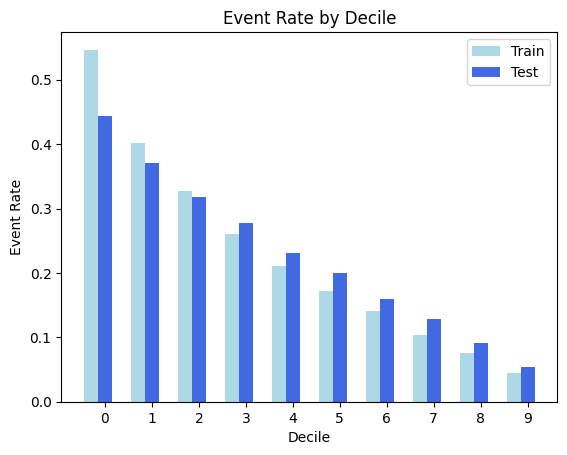

In [ ]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

Insight final:
- O Modelo é menos estável que o modelo 4 pois a diferença entre a barra de treino e teste em cada decil é um maior que a do modelo anterior.E a diferença enrtre KS treino e teste é maior que a do modelo anterior.
- O Modelo tem uma performance melhor em relação ao modelo anterior analisando % de inadimplentes em relação ao total existente nos primeiros decis e % de inadimplentes dentro de cada decil se analisarmos os primeiros decis.
- O Modelo auemntou em 0.004 pontos de KS.
- Devido limitação de poder computacional foi utilizada amostra estatistica signifcativa para treinamento do modelo, pegando 3% da base total.
- Com esse conjunto de variáveis o modelo de melhor performance foi a Regressão Logistica, diferente dos modelos 1,2,3 e 4 em que foi escolhido light gbm.
- O booking de recarga gerou 6 variáveis explicativas com poder moderado de predição através o IV, o que elevou a performance geral do modelo.
- Considerando a performance e o KS atual, o modelo não atende as métricas de meta, uma vez que valor é menor considerando o benchmarking de mercado e também está menor em relação ao modelo atual da claro(KS=33.1).

Tentativas de otimização de performance:
- Aumento de % amostral para treinamento, mais que o atual não é suportado pelo Colab (Testado de 0,1 a 0,4)


## Salvar melhor modelo

In [ ]:
#salvando pickle do modelo para futura utilização. (teria que salvar pickles das etapas anteriores de pre-processamento de dados correto?)
import pickle

with open('vars_regression_5.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

with open('regression_5.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)